# **Prototypical Networks for Few-Shot Learning on Omniglot**

*Based on this [colab notebook](https://colab.research.google.com/drive/1TPL2e3v8zcDK00ABqH3R0XXNJtJnLBCd?usp=sharing).*

This notebook offers a demonstration of metric-based Few-Shot Learning (FSL) using **Prototypical Networks** on the **Omniglot** benchmark.

---

## **1. Background**

### **1.1 Few-Shot Learning (FSL)**

In FSL we evaluate and train **episodically**. Each **episode** samples $N$ classes (*N-way*). For each class $K$, we are given a small **support set** $S_k$ of size $K$ (*K-shot*) and a **query set** $Q_k$.  

The learner must classify each query among the $N$ classes using **only** the $N \times K$ labeled supports from that episode.  
Crucially, the classes in an episode are typically **unseen during training**; the model must leverage the supports as a “catalog” describing what each class looks like.

> **Example (3-way 2-shot):** the support contains 2 examples for each of 3 classes. For every query image, the learner must predict its label among those 3 classes.

In practice, many methods are **metric-based**:  
1. use an encoder to project images into a **feature space**,  
2. classify queries by comparing them to the supports in that space.

*(Evaluation tip: report mean accuracy over many episodes, e.g. $T = 10{,}000$, with a 95% confidence interval.)*


![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

### **1.2 Prototypical Networks**

Let $ f_\phi(\cdot) $ be an embedding function (a neural encoder).  
For each class $K$ in an episode, we compute the **prototype** as the mean embedding of its supports:

$$
\mathbf{c}_k \;=\; \frac{1}{|S_k|} \sum_{(x,y)\in S_k} f_\phi(x).
$$

Given a query $x$, we score classes via the **negative distance** between its embedding and each prototype:


$$
\text{logit}_k(x) \;=\; -\, d\!\big(f_\phi(x), \mathbf{c}_k\big),
$$

where $ d(\cdot,\cdot) $ is typically the **squared Euclidean** or **(negative) cosine** distance.

The class probabilities are obtained with a softmax:

$$
p_\phi(y = k \mid x) \;=\;
\frac{\exp\!\left(-d(f_\phi(x), \mathbf{c}_k)\right)}
{\sum_{j=1}^{N} \exp\!\left(-d(f_\phi(x), \mathbf{c}_j)\right)}.
$$

The model is trained **episodically** by minimizing the **cross-entropy loss** over the query labels within each episode.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)


**Notes (implementation):**
- The forward pass usually receives **support images, support labels, and query images**; prototypes are computed on-the-fly.  
- A common backbone is a pretrained CNN (e.g., ResNet-18) with its classifier head removed.  
- When using cosine distance, embeddings are often **$\ell_2$-normalized**:  
  $ f_\phi(x) \leftarrow f_\phi(x) / \| f_\phi(x) \| $.


### **1.3 Omniglot dataset**
We'll use [Omniglot](https://github.com/brendenlake/omniglot), a popular MNIST-like benchmark
for few-shot classification. It contains 1623 characters from 50 different alphabets. Each character has been written by
20 different people.

It's part of the `torchivision` package, so it's easy to download
and work with.

---

## **2. Practice**

In [1]:
import numpy as np
import pandas as pd
import torch
import math
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor, nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, utils
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
from functools import partial
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
# Reproducibility
SEED = 42
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

In [3]:
# Few-shot episode configuration
N_WAY = 5        # Number of classes per task
K_SHOT = 5       # Support examples per class
Q_QUERY = 10     # Query examples per class

# Training configuration
FREEZE_BACKBONE = True  # If only last backbone block is trained
N_TRAINING_TASKS = 20_000   # Number of training episodes
N_VAL_TASKS = 1_000         # Number of validation episodes
N_TEST_TASKS = 1_000        # Number of test episodes

# Validation setting
LOG_EVERY = 20
VAL_EVERY = 500            # validate every VAL_EVERY episodes
PATIENCE  = 5              # early stopping after PATIENCE consecutive downgrades

In [26]:
from torchvision import utils as vutils
import matplotlib.pyplot as plt

def plot_images(images: torch.Tensor, title: str, images_per_row: int):
    """
    images: (B, C, H, W)
    """
    grid = vutils.make_grid(images, nrow=images_per_row, padding=1)  # niente bordi tra immagini
    plt.figure()
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')     # rimuove assi e griglia
    plt.tight_layout()
    plt.show()


### **2.1 Environment**

#### 2.1.1 Omniglot dataset

We prepare the Omniglot dataset:

In [5]:
image_size = 28

train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])

In [6]:
train_full = Omniglot(root="./data", background=True, transform=train_tf, download=True)
val_full   = Omniglot(root="./data", background=True, transform=eval_tf,  download=True)
test_set   = Omniglot(root="./data", background=False, transform=eval_tf, download=True)

100%|██████████| 9.46M/9.46M [00:00<00:00, 254MB/s]
100%|██████████| 6.46M/6.46M [00:00<00:00, 261MB/s]


In [7]:
def get_dataset_labels(ds):
    """
    Return a 1D numpy array of dataset labels for common torchvision datasets.
    Tries several known attributes, then falls back to a light scan.
    """
    # 1) Standard torchvision datasets (e.g., CIFAR, MNIST)
    if hasattr(ds, "targets") and len(ds.targets) > 0:
        return np.array(ds.targets)

    # 2) Some datasets use .labels
    if hasattr(ds, "labels") and len(ds.labels) > 0:
        return np.array(ds.labels)

    # 3) Omniglot (torchvision) keeps a flat list of (path, class_idx)
    if hasattr(ds, "_flat_character_images") and len(ds._flat_character_images) > 0:
        return np.array([lbl for _, lbl in ds._flat_character_images])

    # 4) Fallback: iterate WITHOUT forcing heavy transforms if possible.
    labels = []
    for i in range(len(ds)):
        _, y = ds[i]
        labels.append(int(y))
    return np.array(labels)

#### 2.1.2 Episodic DataLoader

Now that we have a model, we need to evaluate it on **few-shot tasks**.
A standard PyTorch `DataLoader` builds mini-batches of images without
considering whether they belong to a support or query set.
For few-shot learning, we need something more specific:

1. **Balanced classes**: each batch must contain examples from exactly `n_way` classes.
2. **Support / query split**: for each class, we need `k_shot` images in the support set
   and `q_query` images in the query set.

To achieve this, we use a custom **task sampler** and a custom **collate function**:

- The sampler samples `n_way` classes and then `k_shot + q_query` images from each class.
- The collate function splits the sampled images into 5 items:
  1. support images
  2. support labels (in range `[0, n_way)`)
  3. query images
  4. query labels (in range `[0, n_way)`)
  5. a mapping from episodic labels `[0, n_way)` to their original dataset labels

This way, each batch is a complete *episode* for few-shot training or evaluation.


In [8]:
def episodic_collate_fn(
    batch,
    n_way: int,
    k_shot: int,
    q_query: int,
):
    """
    Return the same output format as easy-fsl's TaskSampler.episodic_collate_fn.

    Args:
        batch: list of (image, label) pairs sampled episodically, grouped by class.
    Returns:
        support_images: (n_way * k_shot, C, H, W)
        support_labels: (n_way * k_shot,)   values in [0, n_way)
        query_images:   (n_way * q_query, C, H, W)
        query_labels:   (n_way * q_query,)  values in [0, n_way)
        true_class_ids: list[int] of original dataset class ids (len = n_way)
    """
    # Unzip images and labels
    imgs, labs = zip(*batch)

    # Ensure tensors (most torchvision datasets already return tensors)
    if not torch.is_tensor(imgs[0]):
        # If your dataset returns PIL images, convert to tensor here or in the dataset __getitem__
        imgs = [torch.as_tensor(np.array(im)).permute(2, 0, 1) for im in imgs]

    images = torch.stack(imgs)              # (n_way*(k_shot+q_query), C, H, W)
    labels = torch.tensor([int(l) for l in labs])  # original dataset labels

    n_per = k_shot + q_query
    assert images.size(0) == n_way * n_per, "Batch size doesn't match n_way*(k_shot+q_query)"

    # Reshape by class assuming sampler concatenated per-class blocks in order
    images = images.view(n_way, n_per, *images.shape[1:])  # (N, S+Q, C, H, W)
    labels = labels.view(n_way, n_per)                     # (N, S+Q)

    # True class ids = first label of each class block (original dataset ids)
    true_class_ids = [int(labels[i, 0].item()) for i in range(n_way)]

    # Map dataset labels -> episodic labels [0..n_way)
    label_map = {cid: i for i, cid in enumerate(true_class_ids)}
    episodic_labels = labels.clone()
    for i, cid in enumerate(true_class_ids):
        episodic_labels[i] = label_map[cid]

    # Split support / query
    support_images = images[:, :k_shot].reshape(-1, *images.shape[2:])
    query_images   = images[:, k_shot:].reshape(-1, *images.shape[2:])
    support_labels = episodic_labels[:, :k_shot].reshape(-1)
    query_labels   = episodic_labels[:, k_shot:].reshape(-1)

    return support_images, support_labels, query_images, query_labels, true_class_ids

In [9]:
def test_episodic_sampler(n_way, k_shot, q_query, n_tasks):
    """
    Yield lists of indices for episodic tasks.
    Each list has n_way * (k_shot + q_query) indices, grouped by class.
    """
    n_per_class = k_shot + q_query
    for _ in range(n_tasks):
        chosen = np.random.choice(list(class_indices.keys()), size=n_way, replace=False)
        batch = []
        for c in chosen:
            pool = class_indices[c]
            if len(pool) < n_per_class:
                raise ValueError(
                    f"Class {c} has only {len(pool)} samples; need {n_per_class} "
                    f"(k_shot + q_query)."
                )
            idx = np.random.choice(pool, size=n_per_class, replace=False)
            batch.append(idx)
        # Concatenate in the order of 'chosen' so we can reshape by class later
        yield np.concatenate(batch)

In [10]:
# We retrieve labels
labels_test = get_dataset_labels(test_set)
class_indices = {c: np.where(labels_test == c)[0] for c in np.unique(labels_test)}

# Build episodic DataLoader
collate = partial(episodic_collate_fn, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY)

test_loader = DataLoader(
    test_set,
    batch_sampler=list(test_episodic_sampler(N_WAY, K_SHOT, Q_QUERY, N_TEST_TASKS)),
    collate_fn=collate,
    num_workers=2,
    pin_memory=True,
)

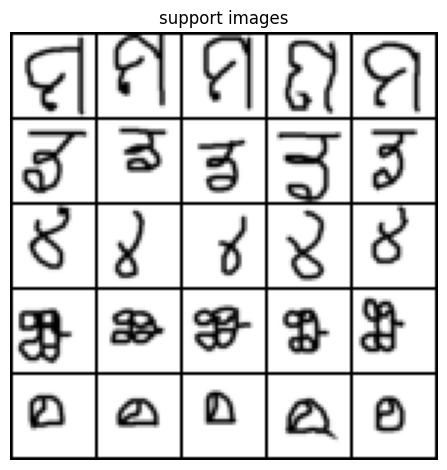

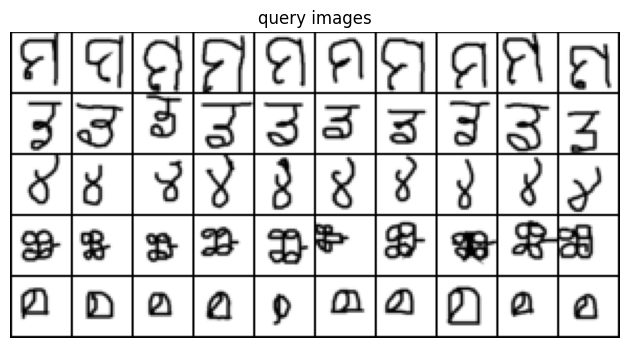

In [27]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=K_SHOT)
plot_images(example_query_images, "query images", images_per_row=Q_QUERY)

#### 2.1.3 Prototypical Network module

Now, we define Prototypical Networks as a torch module:

1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by a `Flatten`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

In [12]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module, metric: str = "sqeuclidean"):
        """
        Prototypical Networks module.

        Args:
            backbone: feature extractor (e.g. ResNet18 without final FC).
            metric: distance metric ("sqeuclidean", "euclidean", "cosine").
        """
        super().__init__()
        self.backbone = backbone
        self.metric = metric

    def _compute_prototypes(self, z_support: torch.Tensor, support_labels: torch.Tensor):
        """
        Compute class prototypes as the mean of support embeddings.

        Args:
            z_support: support embeddings, shape (Ns, D)
            support_labels: support labels, shape (Ns,)

        Returns:
            prototypes: (N, D)
            classes: (N,) tensor with the class ids (order matches prototypes)
        """
        classes = torch.unique(support_labels)
        protos = []
        for c in classes:
            mask = (support_labels == c)
            proto = z_support[mask].mean(dim=0)
            protos.append(proto)
        prototypes = torch.stack(protos, dim=0)
        return prototypes, classes

    def _pairwise_distance(self, z_query: torch.Tensor, prototypes: torch.Tensor) -> torch.Tensor:
        """
        Compute distances between query embeddings and prototypes.

        Args:
            z_query: (Nq, D)
            prototypes: (N, D)

        Returns:
            distances: (Nq, N)
        """
        if self.metric == "sqeuclidean":
            q2 = (z_query ** 2).sum(dim=1, keepdim=True)      # (Nq, 1)
            p2 = (prototypes ** 2).sum(dim=1, keepdim=True).T # (1, N)
            cross = z_query @ prototypes.T                    # (Nq, N)
            d2 = q2 + p2 - 2 * cross
            return d2.clamp_min(0.0)
        elif self.metric == "euclidean":
            return torch.cdist(z_query, prototypes, p=2)
        elif self.metric == "cosine":
            zq = F.normalize(z_query, dim=1)
            pr = F.normalize(prototypes, dim=1)
            return 1.0 - (zq @ pr.T)
        else:
            raise ValueError(f"Unknown metric: {self.metric}")

    def forward(
        self,
        support_images: torch.Tensor,   # (Ns, C, H, W)
        support_labels: torch.Tensor,   # (Ns,) episodic labels [0..N-1]
        query_images: torch.Tensor,     # (Nq, C, H, W)
    ):
        z_support = self.backbone(support_images)
        z_query   = self.backbone(query_images)

        prototypes, classes = self._compute_prototypes(z_support, support_labels)

        dists = self._pairwise_distance(z_query, prototypes)
        scores = -dists
        return scores, classes


# Build backbone (ResNet18 pre-trained on ImageNet, output = 512-D features)
backbone = resnet18(weights="IMAGENET1K_V1")
backbone.fc = nn.Identity()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypicalNetworks(backbone, metric="euclidean").to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


### **2.2 Baseline evaluation**

Let’s draw one episode from the episodic loader, run the model, and print the ground-truth vs predicted class names (when available).

In [13]:
@torch.no_grad()
def evaluate(data_loader: DataLoader):
    per_episode_acc = []
    for (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _true_class_ids,
    ) in data_loader:
        model.eval()
        scores, _ = model(
            support_images.to(device),
            support_labels.to(device),
            query_images.to(device),
        )
        preds = scores.argmax(dim=1).cpu()
        correct = (preds == query_labels).sum().item()
        total = query_labels.numel()
        per_episode_acc.append(correct / total)

    T = len(per_episode_acc)
    mean_acc = sum(per_episode_acc) / T
    var = sum((a - mean_acc) ** 2 for a in per_episode_acc) / (T - 1) if T > 1 else 0.0
    std = math.sqrt(var)
    ci95 = 1.96 * (std / math.sqrt(T)) if T > 0 else 0.0
    return T, float(mean_acc), float(ci95)

In [14]:
model.eval()
T, test_acc, test_ci = evaluate(test_loader)
print(f"[test] acc={100*test_acc:.2f}% ± {100*test_ci:.2f}% (95% CI on {T} tasks)")

[test] acc=86.33% ± 0.43% (95% CI on 1000 tasks)


### **2.3 Episodic fine-tuning**

We now **fine-tune episodically** the model on Omniglot *background* (train) split using episodic tasks.
Each training step:
1) builds an N-way, K-shot task,
2) computes class prototypes from the support set,
3) predicts query labels,
4) updates the encoder with cross-entropy on query predictions.

> Note: for a concise notebook we omit a validation split here, but in practice you should keep a validation episodic loader and monitor it for early stopping.


In [15]:
# Class albels on training/validaton dataset
labels_train_val = get_dataset_labels(train_full)  # shape (N,)
classes_train_val = np.unique(labels_train_val)

# Extract validation set labels
val_ratio = 0.2
n_val = max(1, int(len(classes_train_val) * val_ratio))
val_classes = set(rng.choice(classes_train_val, size=n_val, replace=False))

# Sample indexes for train and validation sets
train_idx = [i for i, y in enumerate(labels_train_val) if y not in val_classes]
val_idx   = [i for i, y in enumerate(labels_train_val) if y in  val_classes]

# Train and validation sets
train_set = Subset(train_full, train_idx)
val_set   = Subset(val_full,   val_idx)

# Label indexes
labels_train = labels_train_val[train_idx]
labels_val   = labels_train_val[val_idx]

# Classes in train/val
train_class_indices = {c: np.where(labels_train == c)[0] for c in np.unique(labels_train)}
val_class_indices   = {c: np.where(labels_val   == c)[0] for c in np.unique(labels_val)}

In [16]:
def train_episodic_sampler(class_indices, n_way, k_shot, q_query, n_tasks, rng):
    n_per_class = k_shot + q_query
    all_classes = list(class_indices.keys())
    for _ in range(n_tasks):
        chosen = rng.choice(all_classes, size=n_way, replace=False)
        batch = []
        for c in chosen:
            pool = class_indices[c]
            if len(pool) < n_per_class:
                raise ValueError(f"Class {c} has only {len(pool)} samples; need {n_per_class}.")
            idx_local = rng.choice(pool, size=n_per_class, replace=False)
            batch.append(idx_local)
        yield np.concatenate(batch)

In [17]:
train_collate = partial(episodic_collate_fn, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY)
val_collate   = partial(episodic_collate_fn, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY)

train_loader = DataLoader(
    train_set,
    batch_sampler=list(train_episodic_sampler(train_class_indices, N_WAY, K_SHOT, Q_QUERY, N_TRAINING_TASKS, rng)),
    collate_fn=train_collate,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    val_set,
    batch_sampler=list(train_episodic_sampler(val_class_indices, N_WAY, K_SHOT, Q_QUERY, N_VAL_TASKS, rng)),
    collate_fn=val_collate,
    num_workers=2,
    pin_memory=True,
)

#### 2.3.1 Loss, optimizer, and backbone freezing

We optimize **cross-entropy** on query predictions using **Adam**.  
You may:
- fine-tune the whole encoder, or
- **freeze** the backbone and train only a small head (not typical for ProtoNets), or
- partially unfreeze (e.g., last residual block) for stability on small K.


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)

# Freeze all but the last block
if FREEZE_BACKBONE:
  for name, p in model.backbone.named_parameters():
      p.requires_grad = ("layer4" in name)  # only train last block

def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        for p in m.parameters():
            p.requires_grad = False
model.backbone.apply(set_bn_eval)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {(trainable/(10**6)):.2f}M (on {sum(p.numel() for p in model.parameters())/(10**6):.2f}M)")

def sliding_average(xs, k=10):
    if len(xs) == 0:
        return 0.0
    if len(xs) < k:
        return float(sum(xs) / len(xs))
    return float(sum(xs[-k:]) / k)

Trainable parameters: 8.39M (on 11.18M)


#### 2.3.2 Episodic training loop

In [22]:
@torch.enable_grad()
def fit_one_episode(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    """
    Single episodic training step: build prototypes on support, predict queries, optimize CE on query labels.
    """
    model.train()
    optimizer.zero_grad()

    scores, _ = model(
        support_images.to(device),
        support_labels.to(device),
        query_images.to(device),
    )
    loss = criterion(scores, query_labels.to(device))
    loss.backward()

    optimizer.step()
    return float(loss.item())

In [23]:
all_loss  = []
best_val_acc = -1.0
patience_ctr = 0
best_state   = None

model.train()
with tqdm(enumerate(train_loader), total=len(train_loader), desc="Episodic training") as tq:
    for step, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _true_class_ids,
    ) in tq:
        # ---- TRAIN ----
        loss_val = fit_one_episode(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_val)

        if step % LOG_EVERY == 0:
            tq.set_postfix(loss=sliding_average(all_loss, LOG_EVERY))

        # ---- PERIODIC VALIDATION ----
        if (step + 1) % VAL_EVERY == 0:
            model.eval()
            T, val_acc, val_ci = evaluate(val_loader)   # evaluation
            tq.write(f"\t[val] step {step+1:05d}: acc={100*val_acc:.2f}% ± {100*val_ci:.2f}% (CI 95% on {T} tasks)")

            # best model checkpoint
            if val_acc > best_val_acc + 1e-6:
                best_val_acc = val_acc
                patience_ctr = 0
                best_state = {
                    "model": deepcopy(model.state_dict()),
                    "optimizer": deepcopy(optimizer.state_dict()),
                    "step": step + 1,
                    "val_acc": best_val_acc,
                }
            else:
                patience_ctr += 1
                if patience_ctr >= PATIENCE:
                    tq.write(f"Early stopping (no improvement for {PATIENCE} validations).")
                    break

            model.train()

# Restore the best model
if best_state is not None:
    model.load_state_dict(best_state["model"])
    optimizer.load_state_dict(best_state["optimizer"])


Episodic training:   3%|▎         | 502/20000 [01:21<28:56:31,  5.34s/it, loss=0.889]

	[val] step 00500: acc=88.11% ± 0.45% (CI 95% on 1000 tasks)


Episodic training:   5%|▌         | 1002/20000 [02:43<23:20:38,  4.42s/it, loss=0.878]

	[val] step 01000: acc=91.28% ± 0.38% (CI 95% on 1000 tasks)


Episodic training:   8%|▊         | 1503/20000 [03:58<20:06:06,  3.91s/it, loss=0.811]

	[val] step 01500: acc=92.35% ± 0.35% (CI 95% on 1000 tasks)


Episodic training:  10%|█         | 2003/20000 [05:15<23:00:02,  4.60s/it, loss=0.635]

	[val] step 02000: acc=92.98% ± 0.36% (CI 95% on 1000 tasks)


Episodic training:  13%|█▎        | 2502/20000 [06:27<23:18:41,  4.80s/it, loss=0.667]

	[val] step 02500: acc=93.02% ± 0.35% (CI 95% on 1000 tasks)


Episodic training:  15%|█▌        | 3002/20000 [07:40<23:36:00,  5.00s/it, loss=0.72]

	[val] step 03000: acc=93.42% ± 0.32% (CI 95% on 1000 tasks)


Episodic training:  18%|█▊        | 3502/20000 [08:52<21:46:30,  4.75s/it, loss=0.644]

	[val] step 03500: acc=93.05% ± 0.35% (CI 95% on 1000 tasks)


Episodic training:  20%|██        | 4002/20000 [10:07<20:23:44,  4.59s/it, loss=0.638]

	[val] step 04000: acc=93.82% ± 0.31% (CI 95% on 1000 tasks)


Episodic training:  23%|██▎       | 4502/20000 [11:18<20:36:41,  4.79s/it, loss=0.655]

	[val] step 04500: acc=93.70% ± 0.32% (CI 95% on 1000 tasks)


Episodic training:  25%|██▌       | 5002/20000 [12:30<18:26:46,  4.43s/it, loss=0.647]

	[val] step 05000: acc=94.50% ± 0.29% (CI 95% on 1000 tasks)


Episodic training:  28%|██▊       | 5502/20000 [13:40<14:37:31,  3.63s/it, loss=0.717]

	[val] step 05500: acc=94.27% ± 0.32% (CI 95% on 1000 tasks)


Episodic training:  30%|███       | 6002/20000 [14:53<16:17:25,  4.19s/it, loss=0.514]

	[val] step 06000: acc=93.96% ± 0.33% (CI 95% on 1000 tasks)


Episodic training:  33%|███▎      | 6503/20000 [16:05<15:26:48,  4.12s/it, loss=0.592]

	[val] step 06500: acc=94.43% ± 0.31% (CI 95% on 1000 tasks)


Episodic training:  35%|███▌      | 7002/20000 [17:17<14:37:54,  4.05s/it, loss=0.6]

	[val] step 07000: acc=94.16% ± 0.32% (CI 95% on 1000 tasks)


Episodic training:  38%|███▊      | 7502/20000 [18:29<17:09:41,  4.94s/it, loss=0.516]

	[val] step 07500: acc=94.91% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  40%|████      | 8002/20000 [19:42<15:02:12,  4.51s/it, loss=0.533]

	[val] step 08000: acc=94.94% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  43%|████▎     | 8502/20000 [20:53<14:17:20,  4.47s/it, loss=0.553]

	[val] step 08500: acc=94.88% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  45%|████▌     | 9002/20000 [22:05<13:24:41,  4.39s/it, loss=0.56]

	[val] step 09000: acc=95.00% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  48%|████▊     | 9503/20000 [23:17<12:08:07,  4.16s/it, loss=0.526]

	[val] step 09500: acc=94.95% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  50%|█████     | 10002/20000 [24:29<12:15:42,  4.42s/it, loss=0.498]

	[val] step 10000: acc=94.51% ± 0.32% (CI 95% on 1000 tasks)


Episodic training:  53%|█████▎    | 10502/20000 [25:41<12:00:24,  4.55s/it, loss=0.486]

	[val] step 10500: acc=95.32% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  55%|█████▌    | 11002/20000 [26:53<11:44:06,  4.70s/it, loss=0.497]

	[val] step 11000: acc=95.12% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  58%|█████▊    | 11502/20000 [28:05<9:09:22,  3.88s/it, loss=0.419] 

	[val] step 11500: acc=94.91% ± 0.32% (CI 95% on 1000 tasks)


Episodic training:  60%|██████    | 12003/20000 [29:17<9:28:49,  4.27s/it, loss=0.458] 

	[val] step 12000: acc=95.44% ± 0.29% (CI 95% on 1000 tasks)


Episodic training:  63%|██████▎   | 12502/20000 [30:31<9:13:46,  4.43s/it, loss=0.425] 

	[val] step 12500: acc=95.21% ± 0.29% (CI 95% on 1000 tasks)


Episodic training:  65%|██████▌   | 13002/20000 [31:43<7:43:06,  3.97s/it, loss=0.502] 

	[val] step 13000: acc=95.52% ± 0.28% (CI 95% on 1000 tasks)


Episodic training:  68%|██████▊   | 13502/20000 [32:55<9:04:20,  5.03s/it, loss=0.479] 

	[val] step 13500: acc=95.27% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  70%|███████   | 14002/20000 [34:07<7:42:42,  4.63s/it, loss=0.444] 

	[val] step 14000: acc=95.16% ± 0.30% (CI 95% on 1000 tasks)


Episodic training:  73%|███████▎  | 14502/20000 [35:18<6:32:21,  4.28s/it, loss=0.53]

	[val] step 14500: acc=95.75% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  75%|███████▌  | 15002/20000 [36:30<6:47:45,  4.90s/it, loss=0.51]

	[val] step 15000: acc=95.38% ± 0.29% (CI 95% on 1000 tasks)


Episodic training:  78%|███████▊  | 15502/20000 [37:42<5:26:33,  4.36s/it, loss=0.435]

	[val] step 15500: acc=95.97% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  80%|████████  | 16002/20000 [38:54<5:34:05,  5.01s/it, loss=0.472]

	[val] step 16000: acc=95.53% ± 0.29% (CI 95% on 1000 tasks)


Episodic training:  83%|████████▎ | 16503/20000 [40:06<3:23:29,  3.49s/it, loss=0.501]

	[val] step 16500: acc=96.04% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  85%|████████▌ | 17002/20000 [41:17<3:15:48,  3.92s/it, loss=0.446]

	[val] step 17000: acc=95.98% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  88%|████████▊ | 17502/20000 [42:29<3:28:51,  5.02s/it, loss=0.415]

	[val] step 17500: acc=96.15% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  90%|█████████ | 18002/20000 [43:41<2:28:34,  4.46s/it, loss=0.464]

	[val] step 18000: acc=96.26% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  93%|█████████▎| 18502/20000 [44:53<2:04:07,  4.97s/it, loss=0.489]

	[val] step 18500: acc=96.04% ± 0.27% (CI 95% on 1000 tasks)


Episodic training:  95%|█████████▌| 19002/20000 [46:05<1:24:04,  5.05s/it, loss=0.417]

	[val] step 19000: acc=95.44% ± 0.29% (CI 95% on 1000 tasks)


Episodic training:  98%|█████████▊| 19502/20000 [47:19<38:30,  4.64s/it, loss=0.43]

	[val] step 19500: acc=95.48% ± 0.30% (CI 95% on 1000 tasks)


Episodic training: 100%|██████████| 20000/20000 [48:31<00:00,  6.87it/s, loss=0.393]

	[val] step 20000: acc=96.19% ± 0.26% (CI 95% on 1000 tasks)


#### Final evaluation

After the episodic fine-tuning, evaluate again on the **test split** with episodic testing (same as before), reporting **mean accuracy ± 95% CI** over `N_EVAL_TASKS` episodes.


In [24]:
model.eval()
T, test_acc, test_ci = evaluate(test_loader)
print(f"[test] acc={100*test_acc:.2f}% ± {100*test_ci:.2f}% (95% CI on {T} tasks)")

[test] acc=94.58% ± 0.30% (95% CI on 1000 tasks)
